In [32]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings("ignore")

In [33]:
df = yf.download("BTC-USD", start = "2024-11-10", end = "2024-11-11", interval='1m')
qty = 0.01

[*********************100%***********************]  1 of 1 completed


In [34]:
def get_supertrend(high, low, close, lookback, multiplier):
    
    # ATR
    
    tr1 = pd.DataFrame(high - low)
    tr2 = pd.DataFrame(abs(high - close.shift(1)))
    tr3 = pd.DataFrame(abs(low - close.shift(1)))
    frames = [tr1, tr2, tr3]
    tr = pd.concat(frames, axis = 1, join = 'inner').max(axis = 1)
    atr = tr.ewm(lookback).mean()
    
    # H/L AVG AND BASIC UPPER & LOWER BAND
    
    hl_avg = (high + low) / 2
    upper_band = (hl_avg + multiplier * atr).dropna()
    lower_band = (hl_avg - multiplier * atr).dropna()
    
    # FINAL UPPER BAND
    final_bands = pd.DataFrame(columns = ['upper', 'lower'])
    final_bands.iloc[:,0] = [x for x in upper_band - upper_band]
    final_bands.iloc[:,1] = final_bands.iloc[:,0]
    for i in range(len(final_bands)):
        if i == 0:
            final_bands.iloc[i,0] = 0
        else:
            if (upper_band[i] < final_bands.iloc[i-1,0]) | (close[i-1] > final_bands.iloc[i-1,0]):
                final_bands.iloc[i,0] = upper_band[i]
            else:
                final_bands.iloc[i,0] = final_bands.iloc[i-1,0]
    
    # FINAL LOWER BAND
    
    for i in range(len(final_bands)):
        if i == 0:
            final_bands.iloc[i, 1] = 0
        else:
            if (lower_band[i] > final_bands.iloc[i-1,1]) | (close[i-1] < final_bands.iloc[i-1,1]):
                final_bands.iloc[i,1] = lower_band[i]
            else:
                final_bands.iloc[i,1] = final_bands.iloc[i-1,1]
    
    # SUPERTREND
    
    supertrend = pd.DataFrame(columns = [f'supertrend_{lookback}'])
    supertrend.iloc[:,0] = [x for x in final_bands['upper'] - final_bands['upper']]
    
    for i in range(len(supertrend)):
        if i == 0:
            supertrend.iloc[i, 0] = 0
        elif supertrend.iloc[i-1, 0] == final_bands.iloc[i-1, 0] and close[i] < final_bands.iloc[i, 0]:
            supertrend.iloc[i, 0] = final_bands.iloc[i, 0]
        elif supertrend.iloc[i-1, 0] == final_bands.iloc[i-1, 0] and close[i] > final_bands.iloc[i, 0]:
            supertrend.iloc[i, 0] = final_bands.iloc[i, 1]
        elif supertrend.iloc[i-1, 0] == final_bands.iloc[i-1, 1] and close[i] > final_bands.iloc[i, 1]:
            supertrend.iloc[i, 0] = final_bands.iloc[i, 1]
        elif supertrend.iloc[i-1, 0] == final_bands.iloc[i-1, 1] and close[i] < final_bands.iloc[i, 1]:
            supertrend.iloc[i, 0] = final_bands.iloc[i, 0]
    
    supertrend = supertrend.set_index(upper_band.index)
    supertrend = supertrend.dropna()[1:]
    
    # ST UPTREND/DOWNTREND
    
    upt = []
    dt = []
    close = close.iloc[len(close) - len(supertrend):]

    for i in range(len(supertrend)):
        if close[i] > supertrend.iloc[i, 0]:
            upt.append(supertrend.iloc[i, 0])
            dt.append(np.nan)
        elif close[i] < supertrend.iloc[i, 0]:
            upt.append(np.nan)
            dt.append(supertrend.iloc[i, 0])
        else:
            upt.append(np.nan)
            dt.append(np.nan)
            
    st, upt, dt = pd.Series(supertrend.iloc[:, 0]), pd.Series(upt), pd.Series(dt)
    upt.index, dt.index = supertrend.index, supertrend.index
    
    return st, upt, dt, atr

In [35]:
df.index

DatetimeIndex(['2024-11-10 00:00:00+00:00', '2024-11-10 00:02:00+00:00',
               '2024-11-10 00:05:00+00:00', '2024-11-10 00:06:00+00:00',
               '2024-11-10 00:07:00+00:00', '2024-11-10 00:10:00+00:00',
               '2024-11-10 00:11:00+00:00', '2024-11-10 00:12:00+00:00',
               '2024-11-10 00:13:00+00:00', '2024-11-10 00:14:00+00:00',
               ...
               '2024-11-10 23:42:00+00:00', '2024-11-10 23:44:00+00:00',
               '2024-11-10 23:46:00+00:00', '2024-11-10 23:48:00+00:00',
               '2024-11-10 23:50:00+00:00', '2024-11-10 23:52:00+00:00',
               '2024-11-10 23:53:00+00:00', '2024-11-10 23:54:00+00:00',
               '2024-11-10 23:56:00+00:00', '2024-11-10 23:58:00+00:00'],
              dtype='datetime64[ns, UTC]', name='Datetime', length=919, freq=None)

In [49]:
df

Price,Adj Close,Close,High,Low,Open,Volume,st,s_upt,st_dt,atr
Ticker,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD,,,,
Datetime,,,,,,,,,,
2024-11-10 00:00:00+00:00,76721.085938,76721.085938,76721.085938,76721.085938,76721.085938,0,NaN,NaN,NaN,0.000000
2024-11-10 00:02:00+00:00,76663.453125,76663.453125,76663.453125,76663.453125,76663.453125,0,76754.018973,NaN,76754.018973,30.188616
2024-11-10 00:05:00+00:00,76580.656250,76580.656250,76580.656250,76580.656250,76580.656250,43026432,76728.916352,NaN,76728.916352,49.420034
2024-11-10 00:06:00+00:00,76610.031250,76610.031250,76610.031250,76610.031250,76610.031250,14481408,76728.916352,NaN,76728.916352,43.671286
2024-11-10 00:07:00+00:00,76650.335938,76650.335938,76650.335938,76650.335938,76650.335938,6422528,76728.916352,NaN,76728.916352,42.863922
...,...,...,...,...,...,...,...,...,...,...
2024-11-10 23:52:00+00:00,80386.164062,80386.164062,80386.164062,80386.164062,80386.164062,34791424,80394.561745,NaN,80394.561745,65.457320
2024-11-10 23:53:00+00:00,80408.390625,80408.390625,80408.390625,80408.390625,80408.390625,29843456,80223.808872,80223.808872,NaN,61.527251


In [36]:
df['st'], df['s_upt'], df['st_dt'], df['atr'] = get_supertrend(df['High']['BTC-USD'], df['Low']['BTC-USD'], df['Close']['BTC-USD'], 10, 3)

In [45]:
type(df['High']['BTC-USD'])

pandas.core.series.Series

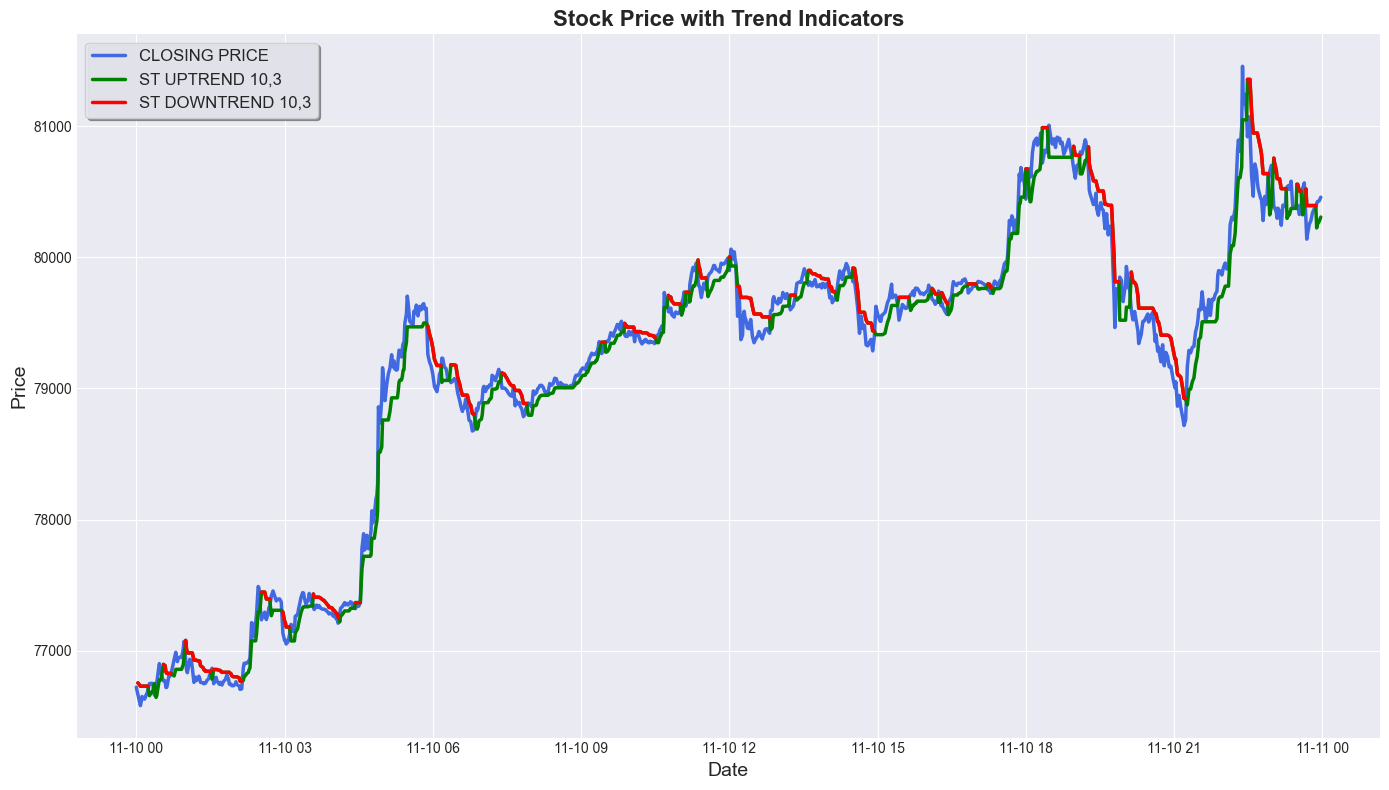

In [37]:
plt.style.use('seaborn-v0_8-darkgrid')
plt.figure(figsize=(14, 8))
plt.plot(df['Adj Close'], linewidth=2.5, label='CLOSING PRICE', color='royalblue')
plt.plot(df['st'], color='green', linewidth=2.5, label='ST UPTREND 10,3')
plt.plot(df['st_dt'], color='red', linewidth=2.5, label='ST DOWNTREND 10,3')
plt.title('Stock Price with Trend Indicators', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.legend(loc='upper left', fontsize=12, frameon=True, framealpha=0.9, shadow=True)
plt.grid(True)
plt.tight_layout()
plt.show()

In [38]:
st = list(df['st'])
st_upt = list(df['s_upt'])
st_dt = list(df['st_dt'])

In [39]:
signal = [0]
for i in range(1, len(st_upt)):
    prev = st_upt[i - 1]
    curr = st_upt[i]

    if np.isnan(prev) and not np.isnan(curr):  # Transition from NaN to a number
        signal.append(1)
    elif not np.isnan(prev) and np.isnan(curr):  # Transition from a number to NaN
        signal.append(-1)
    else:
        signal.append(0)

close = list(df['Close']['BTC-USD'])

In [40]:
pnl = []
def buy_side_testing(signal, close):
    buy_price = 0
    close_price = 0
    status = 0
    for i in range(len(signal)):
        close_price = close[i]
        if signal[i] == 1:
            buy_price = close[i]
            status = 1

        elif signal[i] == -1 and status == 1:
            close_price = st_upt[i-1]
            trade_pnl = (close_price - buy_price) * qty
            status = 0
            print("Buy Price: ", buy_price)
            print("Close Price: ", close_price)
            print("Profit: ", trade_pnl)
            print("-------------------------------------------")
            pnl.append(trade_pnl)



def sell_side_testing(signal, close):
    sell_price = 0
    close_price = 0
    status = 0
    for i in range(len(signal)):
        close_price = close[i]
        if signal[i] == -1:
            sell_price = close[i]
            status = 1
        elif signal[i] == 1 and status == 1:
            close_price = st_dt[i-1]
            trade_pnl = (sell_price - close_price) * qty

            print("Sell Price: ", sell_price)
            print("Close Price: ", close_price)
            print("Profit: ", trade_pnl)
            print("-------------------------------------------")
            pnl.append(trade_pnl)
        
     

buy_side_testing(signal, close)
sell_side_testing(signal, close)

Buy Price:  76748.8046875
Close Price:  76685.79222313313
Profit:  -0.6301246436686779
-------------------------------------------
Buy Price:  76752.390625
Close Price:  76777.84555727418
Profit:  0.25454932274180464
-------------------------------------------
Buy Price:  76933.0859375
Close Price:  76945.70593296144
Profit:  0.1261999546144216
-------------------------------------------
Buy Price:  76865.546875
Close Price:  76781.82107784387
Profit:  -0.8372579715613392
-------------------------------------------
Buy Price:  76870.96875
Close Price:  77295.98891650373
Profit:  4.250201665037312
-------------------------------------------
Buy Price:  77416.890625
Close Price:  77307.9913716798
Profit:  -1.088992533201963
-------------------------------------------
Buy Price:  77200.2890625
Close Price:  77340.05933962164
Profit:  1.3977027712164272
-------------------------------------------
Buy Price:  77272.4375
Close Price:  77323.3887836205
Profit:  0.5095128362049581
------------

In [41]:
(sum(pnl))

50.73082091920426

In [42]:
len(pnl) * 100000 * qty * 2

140000.0

In [43]:
qty * 100000 * 0.0002 * 2 * len(pnl)

28.0

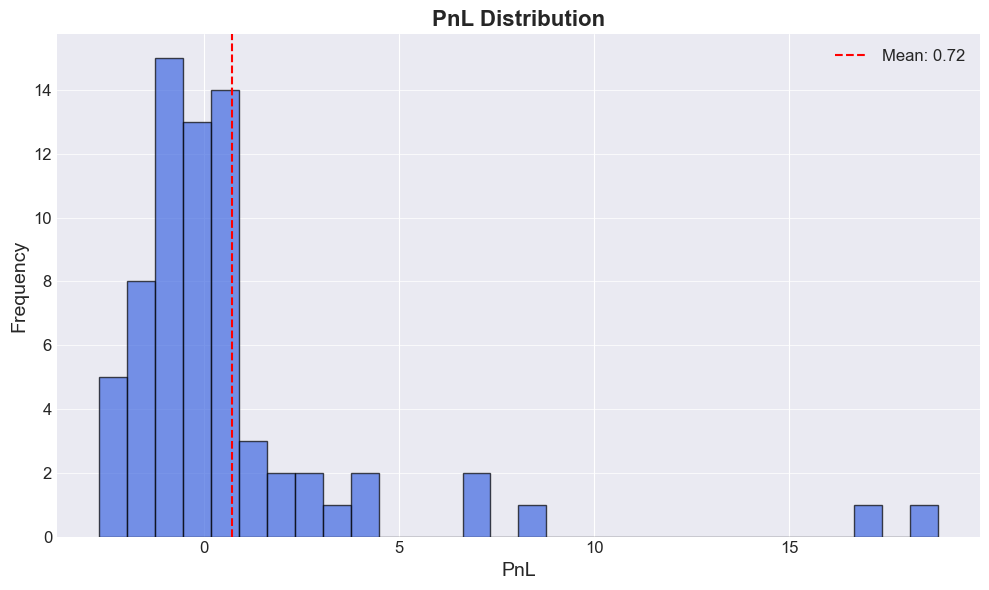

In [44]:
# Aesthetic Histogram Plot
plt.style.use('seaborn-v0_8-darkgrid')  # Apply a pleasing style (e.g., 'seaborn', 'ggplot', etc.)

plt.figure(figsize=(10, 6))  # Set the figure size
plt.hist(pnl, bins=30, color='royalblue', edgecolor='black', alpha=0.7)  # Customize the histogram
plt.title("PnL Distribution", fontsize=16, fontweight='bold')  # Add a title
plt.xlabel("PnL", fontsize=14)  # Add a label for the x-axis
plt.ylabel("Frequency", fontsize=14)  # Add a label for the y-axis

# Add a grid for better readability
plt.grid(axis='y', alpha=0.75)

# Enhance tick size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Optional: Add a vertical line for the mean
plt.axvline(np.mean(pnl), color='red', linestyle='dashed', linewidth=1.5, label=f'Mean: {np.mean(pnl):.2f}')
plt.legend(fontsize=12)

plt.tight_layout()  # Adjust spacing
plt.show()
